
# **Task‑1 (Final v4)** — Predicting Treatment Delay ≥ 90 Days in Oral Cancer (SEER)

This notebook extends **v3** by integrating reviewer‑ready fixes:
- **Train‑only model selection** by CV (primary metric **PR‑AUC**).
- **Leak‑free calibration:** out‑of‑fold (OOF) isotonic for CatBoost, `CalibratedClassifierCV` for sklearn models.
- **Uncertainty:** **95% CIs** for **PR‑AUC** (bootstrap) and **ROC‑AUC** (DeLong).
- **Decision Curve Analysis** for clinical utility.
- Keeps all EDA and decision‑focused reporting (F2‑opt threshold, PPV‑target, Top‑K, rural–urban subgroups, risk deciles).


In [3]:
!pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [4]:

# === 1) Environment & Packages ===
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional libraries
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

try:
    from catboost import CatBoostClassifier, Pool
    CAT_AVAILABLE = True
except Exception:
    CAT_AVAILABLE = False

try:
    from scipy.stats import chi2_contingency, norm
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("XGB available:", XGB_AVAILABLE, "| CatBoost available:", CAT_AVAILABLE, "| SciPy available:", SCIPY_OK)


XGB available: True | CatBoost available: True | SciPy available: True


In [6]:
# === 2) Configuration & Data Load ===
# If 'df' is already defined in your environment, it will be used; otherwise, we load from Excel.
USE_EXISTING_DF = 'df' in globals()

#@title 2) Set File Path and Sheet Name
USE_GOOGLE_DRIVE = True
EXCEL_PATH = "/content/drive/MyDrive/Colab Notebooks/OralCancerData0220.xlsx"
SHEET_NAME = "Oral Cancer Data 02.20"

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

if not USE_EXISTING_DF:
    assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
    df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
    print("Loaded from Excel:", df.shape)
else:
    print("Using in-memory df:", df.shape)

print("Columns ({}):".format(df.shape[1]))
print(list(df.columns)[:20], "...")

Mounted at /content/drive
Loaded from Excel: (114084, 74)
Columns (74):
['Patient ID', 'Age recode with <1 year olds', 'Race recode (White, Black, Other)', 'Sex', 'Year of diagnosis', 'PRCDA 2020', 'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3', 'TNM 7/CS v0204+ Schema (thru 2017)', 'TNM 7/CS v0204+ Schema recode', 'AYA site recode 2020 Revision', 'Lymphoid neoplasm recode 2021 Revision', 'Site recode ICD-O-3 2023 Revision', 'Site recode ICD-O-3 2023 Revision Expanded', 'CS Schema - AJCC 6th Edition', 'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3', 'Laterality', 'Diagnostic Confirmation'] ...


In [7]:

# === 3) Define Target (Delay ≥ 90 days) ===
DELAY_COL = "Time from diagnosis to treatment in days recode"
assert DELAY_COL in df.columns, "Delay column not found."

delay_days = pd.to_numeric(df[DELAY_COL], errors="coerce")
df = df.copy()
df["delay_ge_90d"] = np.where(delay_days >= 90, 1,
                        np.where(delay_days < 90, 0, np.nan))
df = df[~df["delay_ge_90d"].isna()].copy()
df["delay_ge_90d"] = df["delay_ge_90d"].astype(int)

print("Rows after defining target:", df.shape)
print("Delay prevalence (≥90d):", round(df["delay_ge_90d"].mean(), 4))


Rows after defining target: (72947, 75)
Delay prevalence (≥90d): 0.0343


In [8]:

# === 4) Feature Lists (Aligned to Provided Columns) ===
CANDIDATE_FEATURES_ALL = [
    # Demographics
    "Age recode with <1 year olds",
    "Sex",
    "Race recode (White, Black, Other)",  # or "Race/ethnicity"
    "Marital status at diagnosis",
    "Year of diagnosis",

    # Site / histology
    "Site recode ICD-O-3/WHO 2008",
    "Primary Site - labeled",
    "Histologic Type ICD-O-3",

    # Socioeconomic / geography
    "Median household income inflation adj to 2022",
    "Rural-Urban Continuum Code",

    # Stage proxies & tumor burden
    "SEER historic stage A (1973-2015)",
    "Tumor Size Over Time Recode (1988+)",
    "Regional nodes positive (1988+)",
    "Regional nodes examined (1988+)",
]

MODERN_ADDONS = [
    "Derived EOD 2018 T (2018+)",
    "Derived EOD 2018 N (2018+)",
    "Derived EOD 2018 M (2018+)",
    "Derived EOD 2018 Stage Group (2018+)",
    "Tumor Size Summary (2016+)",
]

headers = set(df.columns)
FEATURES = [c for c in CANDIDATE_FEATURES_ALL if c in headers]
MODERN_FEATURES = FEATURES + [c for c in MODERN_ADDONS if c in headers]

print(f"Base usable features: {len(FEATURES)}")
print(f"Modern usable features (if Year>=2018): {len(MODERN_FEATURES)}")


Base usable features: 14
Modern usable features (if Year>=2018): 19


## **EDA — Dataset Overview & Missingness**

Shape: (72947, 75)


,n_rows,n_cols,delay_prevalence
0,72947,75,0.03434


,column,missing_rate
0,Lymphoma - Ann Arbor Stage (1983-2015),0.661453
1,RX Summ--Scope Reg LN Sur (2003+),0.353476
2,Patient ID,0.000000
3,Sex,0.000000
4,Year of diagnosis,0.000000
5,PRCDA 2020,0.000000
6,Site recode ICD-O-3/WHO 2008,0.000000
7,Behavior code ICD-O-3,0.000000
8,TNM 7/CS v0204+ Schema (thru 2017),0.000000
9,Age recode with <1 year olds,0.000000


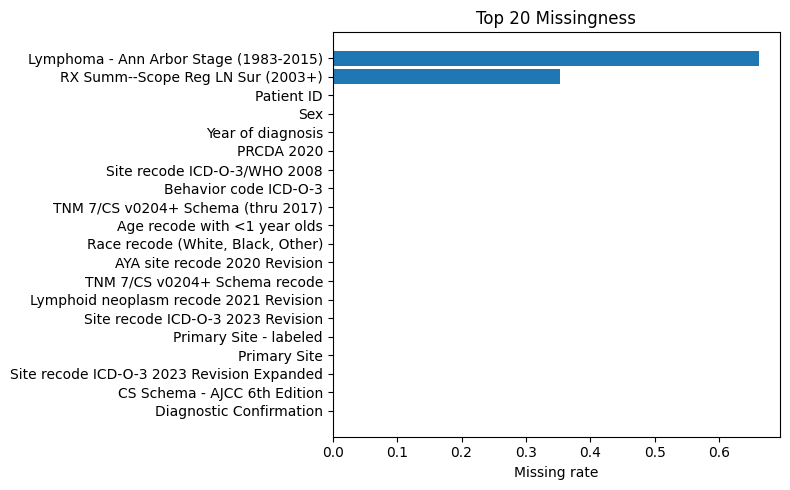

In [9]:

# === 5) EDA: Shape, Basic Counts, Missingness ===
print("Shape:", df.shape)
basic = pd.DataFrame({
    "n_rows": [df.shape[0]],
    "n_cols": [df.shape[1]],
    "delay_prevalence": [df["delay_ge_90d"].mean()]
})
display(basic)

# Missingness percent per column (top 20)
miss = df.isna().mean().sort_values(ascending=False).head(20)
miss_df = miss.to_frame("missing_rate").reset_index().rename(columns={"index": "column"})
display(miss_df)

plt.figure(figsize=(8,5))
plt.barh(miss_df["column"], miss_df["missing_rate"])
plt.gca().invert_yaxis()
plt.xlabel("Missing rate")
plt.title("Top 20 Missingness")
plt.tight_layout(); plt.show()


## **EDA — Target Balance & Delay Distributions**

Delay prevalence (≥90d): 0.0343


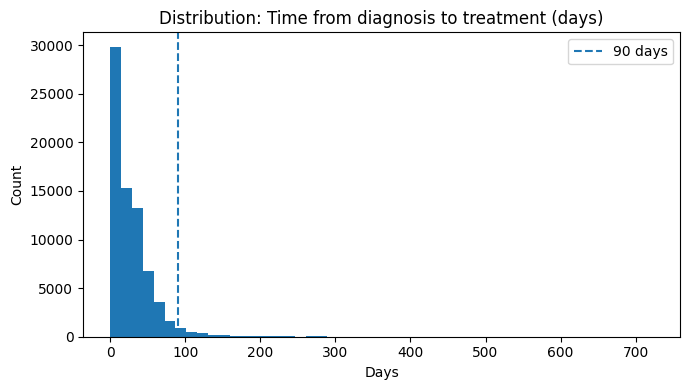

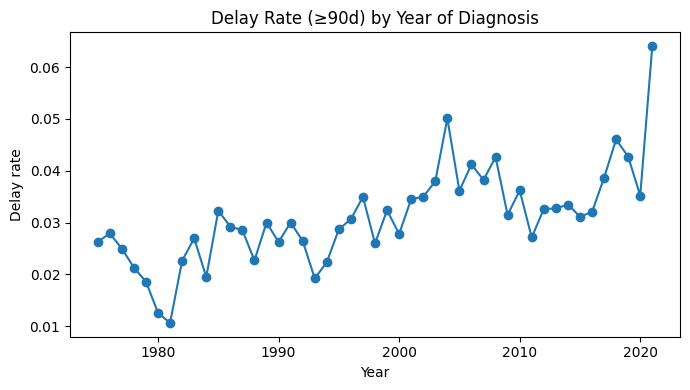

In [10]:

# === 6) EDA: Class Balance & Delay Distribution ===
prev = df["delay_ge_90d"].mean()
print("Delay prevalence (≥90d):", round(prev, 4))

delay_days = pd.to_numeric(df[DELAY_COL], errors="coerce")
plt.figure(figsize=(7,4))
plt.hist(delay_days.dropna(), bins=50)
plt.axvline(90, linestyle="--", label="90 days")
plt.title("Distribution: Time from diagnosis to treatment (days)")
plt.xlabel("Days"); plt.ylabel("Count"); plt.legend()
plt.tight_layout(); plt.show()

if "Year of diagnosis" in df.columns:
    trend = df.groupby("Year of diagnosis")["delay_ge_90d"].mean().reset_index()
    plt.figure(figsize=(7,4))
    plt.plot(trend["Year of diagnosis"], trend["delay_ge_90d"], marker="o")
    plt.title("Delay Rate (≥90d) by Year of Diagnosis")
    plt.xlabel("Year"); plt.ylabel("Delay rate")
    plt.tight_layout(); plt.show()


## **EDA — Key Relationships (Categorical)**

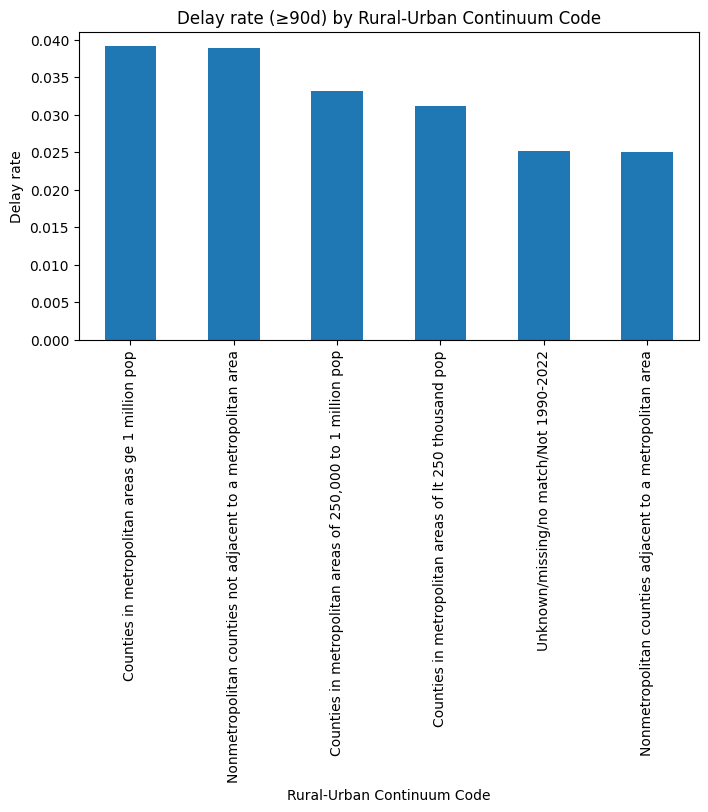

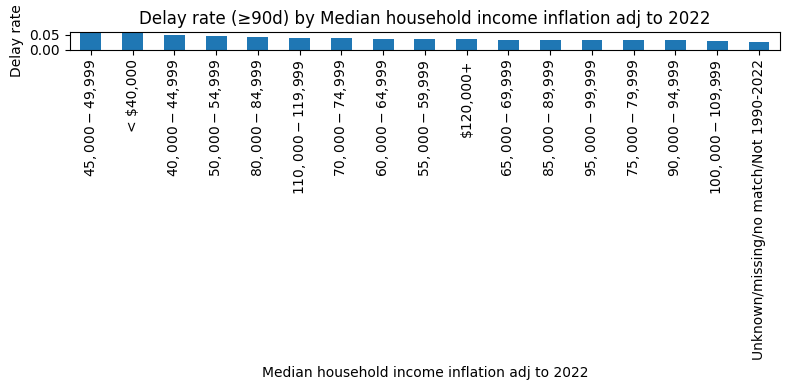

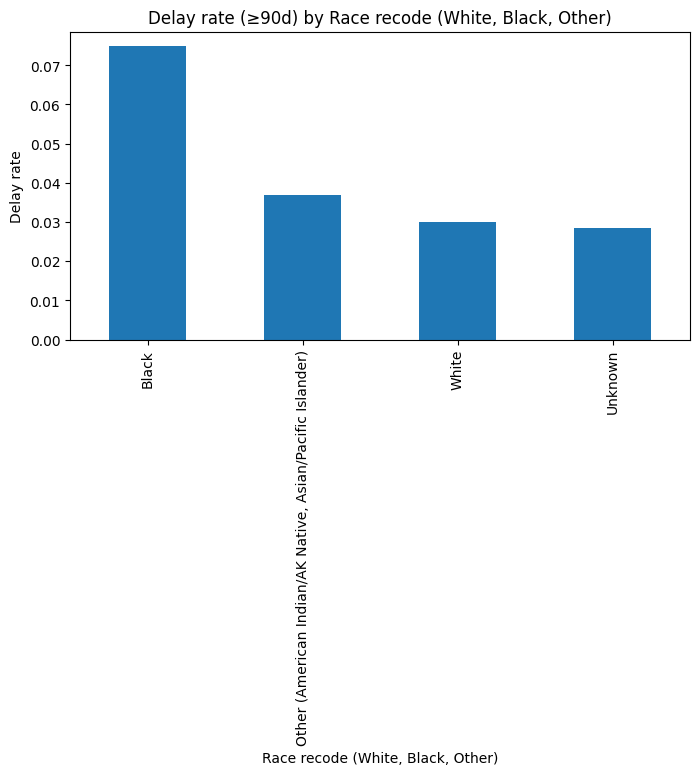

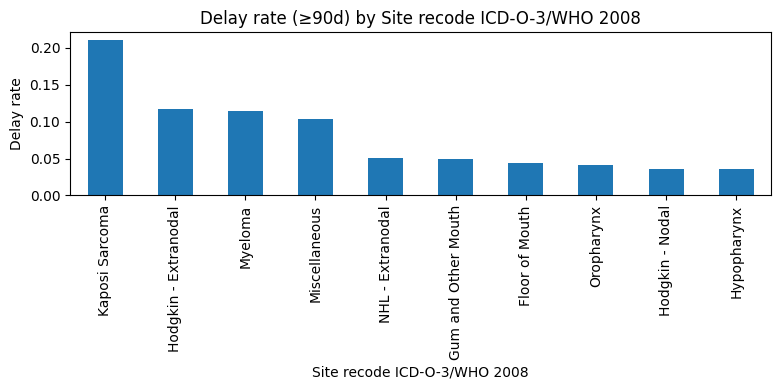

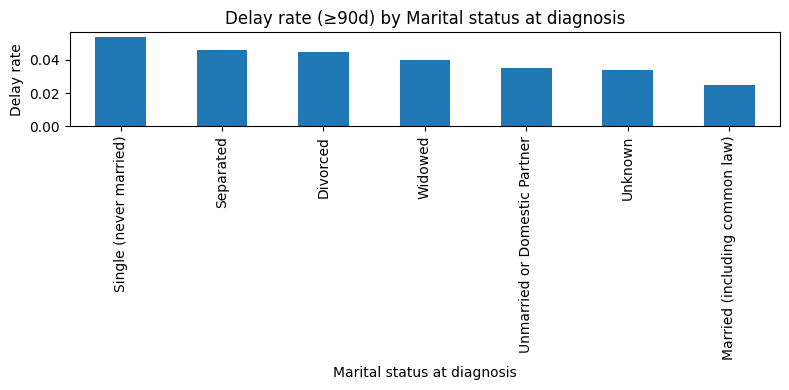

In [11]:

# === 7) EDA: Delay rate by key categorical features ===
def plot_delay_rate_by(col, top_n=None):
    if col not in df.columns:
        print(f"[skip] {col} not found.")
        return
    tab = df.groupby(col)["delay_ge_90d"].mean().sort_values(ascending=False)
    if top_n is not None:
        tab = tab.head(top_n)
    plt.figure(figsize=(8,4))
    tab.plot(kind="bar")
    plt.title(f"Delay rate (≥90d) by {col}")
    plt.ylabel("Delay rate"); plt.tight_layout(); plt.show()

plot_delay_rate_by("Rural-Urban Continuum Code")
plot_delay_rate_by("Median household income inflation adj to 2022")
if "Race recode (White, Black, Other)" in df.columns:
    plot_delay_rate_by("Race recode (White, Black, Other)")
elif "Race/ethnicity" in df.columns:
    plot_delay_rate_by("Race/ethnicity")
plot_delay_rate_by("Site recode ICD-O-3/WHO 2008", top_n=10)
plot_delay_rate_by("Marital status at diagnosis")


## **EDA — Numeric Relationships**

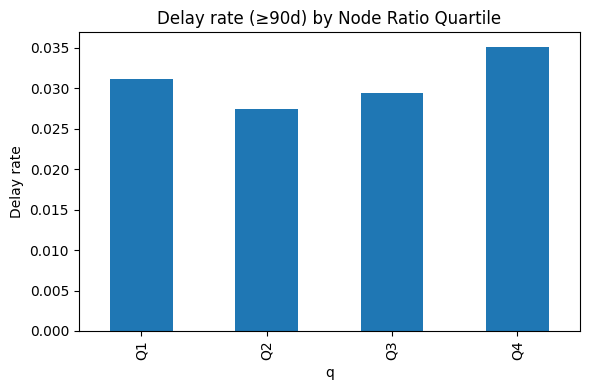

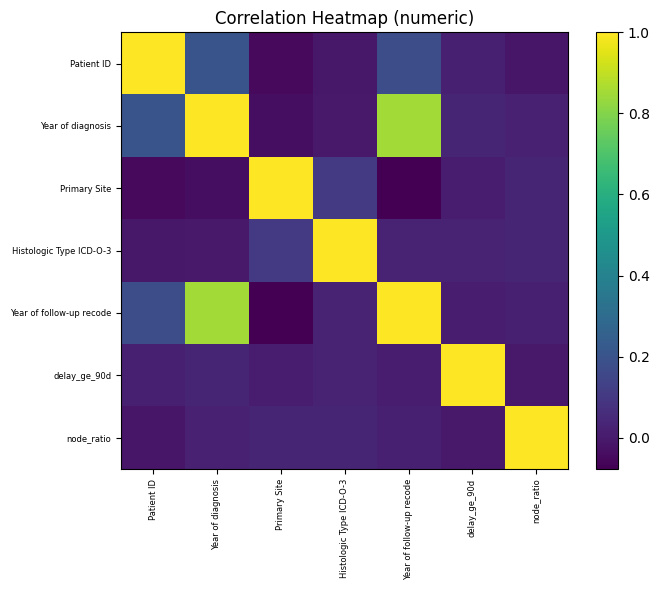

In [13]:

# === 8) EDA: Node ratio quartiles & correlation heatmap ===
if ("Regional nodes positive (1988+)" in df.columns) and ("Regional nodes examined (1988+)" in df.columns):
    nodes_pos = pd.to_numeric(df["Regional nodes positive (1988+)"], errors="coerce")
    nodes_ex  = pd.to_numeric(df["Regional nodes examined (1988+)"], errors="coerce")
    node_ratio = np.where(nodes_ex > 0, nodes_pos / nodes_ex, np.nan)
    df["node_ratio"] = node_ratio

    q = pd.qcut(df["node_ratio"], 5, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
    tmp = pd.DataFrame({"q": q, "y": df["delay_ge_90d"]}).dropna()
    grp = tmp.groupby("q")["y"].mean()
    plt.figure(figsize=(6,4)); grp.plot(kind="bar")
    plt.title("Delay rate (≥90d) by Node Ratio Quartile")
    plt.ylabel("Delay rate"); plt.tight_layout(); plt.show()

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and df[c].notna().sum()>0]
corr = df[num_cols].corr().fillna(0)
plt.figure(figsize=(7,6))
plt.imshow(corr, aspect="auto")
plt.title("Correlation Heatmap (numeric)")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=6)
plt.yticks(range(len(num_cols)), num_cols, fontsize=6)
plt.tight_layout(); plt.show()


## **Modeling — Cohort Selection (All‑years vs Modern)**

In [26]:

# === 9) Modeling: Cohort Selection ===
USE_MODERN = True  # set True for Year>=2018 model with EOD 2018 fields

FEATURES = [c for c in CANDIDATE_FEATURES_ALL if c in df.columns]
MODERN_FEATURES = FEATURES + [c for c in MODERN_ADDONS if c in df.columns]

if USE_MODERN:
    model_df = df[df["Year of diagnosis"] >= 2018].copy()
    use_features = MODERN_FEATURES
else:
    model_df = df.copy()
    use_features = FEATURES

# Add missing flags
MISS_FLAG_COLS = [
    "SEER historic stage A (1973-2015)",
    "Regional nodes positive (1988+)",
    "Regional nodes examined (1988+)",
    "Derived EOD 2018 T (2018+)",
    "Derived EOD 2018 N (2018+)",
    "Derived EOD 2018 M (2018+)",
    "Derived EOD 2018 Stage Group (2018+)",
]
for c in MISS_FLAG_COLS:
    if c in model_df.columns and (c + " [missing]") not in model_df.columns:
        model_df[c + " [missing]"] = model_df[c].isna().astype(int)
        use_features.append(c + " [missing]")

# Optional ordinal mapping for SEER historic stage
if "SEER historic stage A (1973-2015)" in model_df.columns and "SEER historic stage A (1973-2015) [ord]" not in model_df.columns:
    map_stage = {"In situ": 0, "Localized": 1, "Regional": 2, "Distant": 3}
    model_df["SEER historic stage A (1973-2015) [ord]"] = model_df["SEER historic stage A (1973-2015)"].map(map_stage)
    use_features.append("SEER historic stage A (1973-2015) [ord]")

# Finalize features unique order
use_features = [c for i, c in enumerate(use_features) if use_features.index(c) == i]

print("Cohort:", model_df.shape, "| Features:", len(use_features))
print("Prevalence:", round(model_df['delay_ge_90d'].mean(), 4))


Cohort: (12786, 84) | Features: 27
Prevalence: 0.0472


## **Modeling — Preprocessing (robust to mixed types)**

In [29]:

# === 10) Preprocessing ===
X = model_df[use_features].copy()
y = model_df["delay_ge_90d"].astype(int)

# Force numeric for intended numeric columns
for c in ["Regional nodes positive (1988+)", "Regional nodes examined (1988+)", "Tumor Size Summary (2016+)"]:
    if c in X.columns and not pd.api.types.is_numeric_dtype(X[c]):
        X[c] = pd.to_numeric(X[c], errors="coerce")

numeric_cols, categorical_cols = [], []
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

numeric_transformer = Pipeline(steps=[
    ("to_num", FunctionTransformer(lambda Z: pd.DataFrame(Z).apply(pd.to_numeric, errors="coerce"))),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("to_str", FunctionTransformer(lambda Z: Z.astype(str))),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

print("Numeric cols:", len(numeric_cols), "| Categorical cols:", len(categorical_cols))


Numeric cols: 13 | Categorical cols: 14


## **Modeling — Temporal Train/Test Split (Drift‑Aware)**

In [28]:

# === 11) Temporal Train/Test Split ===
CUT_YEAR = 2012 if not USE_MODERN else 2020
train_idx = (model_df["Year of diagnosis"] <= CUT_YEAR)
test_idx  = (model_df["Year of diagnosis"] >  CUT_YEAR)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Prev (train):", round(y_train.mean(),4), "| Prev (test):", round(y_test.mean(),4))


Train: (9507, 27)  Test: (3279, 27)
Prev (train): 0.0414 | Prev (test): 0.064


## **Modeling — Models & Train‑only CV Selection (PR‑AUC primary)**

In [30]:

# === 12) Models & Train-only CV Selection ===
neg_pos_ratio = (y_train.shape[0] - y_train.sum()) / y_train.sum()

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=600, max_depth=None, n_jobs=-1, random_state=SEED, class_weight="balanced_subsample"),
}

if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=1200, max_depth=5, learning_rate=0.03,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=SEED, eval_metric="logloss", n_jobs=-1,
        scale_pos_weight=float(neg_pos_ratio)
    )

# CV evaluation on training for sklearn models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

cv_results = {}
for name, est in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", est)])
    pr = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="average_precision")
    roc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    cv_results[name] = {"cv_pr_auc_mean": pr.mean(), "cv_pr_auc_std": pr.std(), "cv_roc_mean": roc.mean(), "cv_roc_std": roc.std()}
    print(f"{name} | CV PR-AUC: {pr.mean():.3f}±{pr.std():.3f} | CV ROC-AUC: {roc.mean():.3f}±{roc.std():.3f}")

# Manual CV for CatBoost
if CAT_AVAILABLE:
    cat_cols = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]
    cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
    pr_scores, roc_scores = [], []
    for tr, va in skf.split(X_train, y_train):
        tr_pool = Pool(X_train.iloc[tr], y_train.iloc[tr], cat_features=cat_idx)
        va_pool = Pool(X_train.iloc[va], y_train.iloc[va], cat_features=cat_idx)
        cat = CatBoostClassifier(
            iterations=3000, depth=6, learning_rate=0.03,
            loss_function="Logloss", eval_metric="PRAUC",
            class_weights=[1.0, float(neg_pos_ratio)],
            random_seed=SEED, verbose=False
        )
        cat.fit(tr_pool, eval_set=va_pool)
        proba = cat.predict_proba(va_pool)[:,1]
        pr_scores.append(average_precision_score(y_train.iloc[va], proba))
        roc_scores.append(roc_auc_score(y_train.iloc[va], proba))
    cv_results["CatBoost"] = {
        "cv_pr_auc_mean": float(np.mean(pr_scores)),
        "cv_pr_auc_std": float(np.std(pr_scores)),
        "cv_roc_mean": float(np.mean(roc_scores)),
        "cv_roc_std": float(np.std(roc_scores)),
    }
    print(f"CatBoost | CV PR-AUC: {np.mean(pr_scores):.3f}±{np.std(pr_scores):.3f} | CV ROC-AUC: {np.mean(roc_scores):.3f}±{np.std(roc_scores):.3f}")

# Select best by CV PR-AUC (tie-break by CV ROC)
best_name = max(cv_results.keys(), key=lambda k: (cv_results[k]["cv_pr_auc_mean"], cv_results[k]["cv_roc_mean"]))
print("Best model by TRAIN CV PR-AUC:", best_name, cv_results[best_name])


LogisticRegression | CV PR-AUC: 0.085±0.025 | CV ROC-AUC: 0.634±0.040
RandomForest | CV PR-AUC: 0.095±0.015 | CV ROC-AUC: 0.671±0.029
XGBoost | CV PR-AUC: 0.074±0.015 | CV ROC-AUC: 0.616±0.045
CatBoost | CV PR-AUC: 0.122±0.019 | CV ROC-AUC: 0.690±0.027
Best model by TRAIN CV PR-AUC: CatBoost {'cv_pr_auc_mean': 0.122164663037641, 'cv_pr_auc_std': 0.018957483398540812, 'cv_roc_mean': 0.6902678944632905, 'cv_roc_std': 0.026637059976268525}


## **Modeling — Fit Final Model on Train & Leak‑Free Calibration**

In [31]:

# === 13) Final Fit + Calibration without leakage ===
def fit_and_calibrate_sklearn(best_estimator):
    base = Pipeline(steps=[("prep", preprocess), ("clf", best_estimator)])
    cal = CalibratedClassifierCV(base, method="isotonic", cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED))
    cal.fit(X_train, y_train)
    proba_train = cal.predict_proba(X_train)[:,1]
    proba_test  = cal.predict_proba(X_test)[:,1]
    return cal, proba_train, proba_test

def fit_and_calibrate_catboost():
    cat_cols = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]
    cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
    # 1) OOF predictions for calibration on TRAIN
    skf_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    oof = np.zeros(X_train.shape[0])
    for tr, va in skf_local.split(X_train, y_train):
        tr_pool = Pool(X_train.iloc[tr], y_train.iloc[tr], cat_features=cat_idx)
        va_pool = Pool(X_train.iloc[va], y_train.iloc[va], cat_features=cat_idx)
        cat = CatBoostClassifier(
            iterations=3000, depth=6, learning_rate=0.03,
            loss_function="Logloss", eval_metric="PRAUC",
            class_weights=[1.0, float((y_train.shape[0]-y_train.sum())/y_train.sum())],
            random_seed=SEED, verbose=False
        )
        cat.fit(tr_pool, eval_set=va_pool)
        oof[va] = cat.predict_proba(va_pool)[:,1]
    # 2) Fit isotonic on OOF vs y_train
    from sklearn.isotonic import IsotonicRegression
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(oof, y_train.values)
    # 3) Refit CatBoost on FULL TRAIN and get calibrated TEST probs
    full_pool = Pool(X_train, y_train, cat_features=cat_idx)
    final_cat = CatBoostClassifier(
        iterations=3000, depth=6, learning_rate=0.03,
        loss_function="Logloss", eval_metric="PRAUC",
        class_weights=[1.0, float((y_train.shape[0]-y_train.sum())/y_train.sum())],
        random_seed=SEED, verbose=False
    )
    final_cat.fit(full_pool)
    test_pool = Pool(X_test, y_test, cat_features=cat_idx)
    proba_train_full = final_cat.predict_proba(full_pool)[:,1]
    proba_test_full  = final_cat.predict_proba(test_pool)[:,1]
    proba_train_cal = iso.transform(proba_train_full)
    proba_test_cal  = iso.transform(proba_test_full)
    return final_cat, proba_train_cal, proba_test_cal

if best_name == "CatBoost":
    if not CAT_AVAILABLE:
        raise RuntimeError("CatBoost selected by CV but package not available. Install catboost or choose another model.")
    best_model, proba_train_cal, proba_test_cal = fit_and_calibrate_catboost()
else:
    best_model, proba_train_cal, proba_test_cal = fit_and_calibrate_sklearn(models[best_name])

print("Calibrated on train (no leakage) and scored on test.")


Calibrated on train (no leakage) and scored on test.


## **Evaluation — Primary Metrics & Curves (Test Set)**

TEST — ROC-AUC: 0.497 | PR-AUC: 0.067 | Brier: 0.064 | Prevalence: 0.064


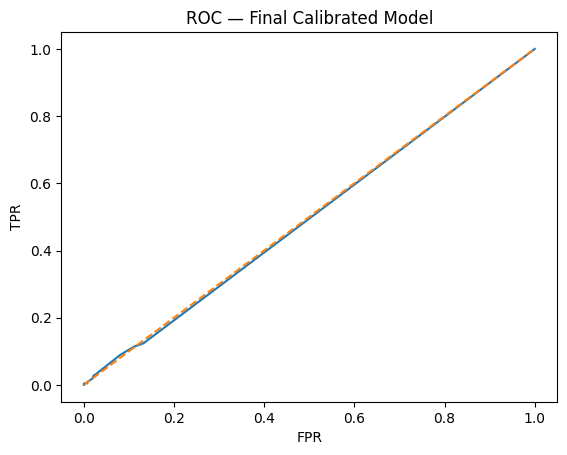

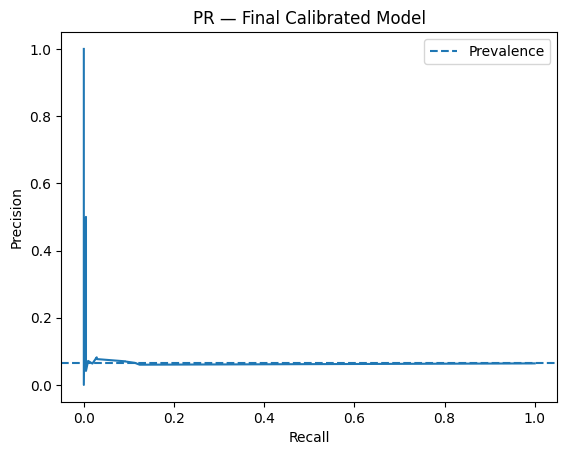

F2-opt threshold: 0.0000 | Precision: 0.064 | Recall: 1.000
Confusion @F2-opt:
 [[   0 3069]
 [   0  210]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      3069
           1      0.064     1.000     0.120       210

    accuracy                          0.064      3279
   macro avg      0.032     0.500     0.060      3279
weighted avg      0.004     0.064     0.008      3279



In [32]:

# === 14) Test Metrics & Curves ===
yte = y_test.values
pte = proba_test_cal

roc = roc_auc_score(yte, pte)
pr  = average_precision_score(yte, pte)
brier = brier_score_loss(yte, pte)
print(f"TEST — ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f} | Brier: {brier:.3f} | Prevalence: {yte.mean():.3f}")

fpr, tpr, _ = roc_curve(yte, pte)
prec, rec, thr = precision_recall_curve(yte, pte)

plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Final Calibrated Model"); plt.show()

plt.figure(); plt.plot(rec, prec)
plt.axhline(y=yte.mean(), linestyle="--", label="Prevalence")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — Final Calibrated Model"); plt.legend(); plt.show()

# F2-opt threshold
beta=2
f2 = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
best_idx = np.nanargmax(f2)
thr_f2 = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"F2-opt threshold: {thr_f2:.4f} | Precision: {prec[best_idx]:.3f} | Recall: {rec[best_idx]:.3f}")
preds_f2 = (pte >= thr_f2).astype(int)
print("Confusion @F2-opt:\n", confusion_matrix(yte, preds_f2))
print(classification_report(yte, preds_f2, digits=3))


## **Evaluation — Operating Points (PPV target & Top‑K)**

In [33]:

# === 15) PPV target (e.g., 10%) and Top-K% ===
target_ppv = 0.10
prec, rec, thr = precision_recall_curve(yte, pte)

cands = [(p, r, t) for p, r, t in zip(prec, rec, np.append(thr, [thr[-1]])) if p >= target_ppv]
if cands:
    p_sel, r_sel, t_sel = max(cands, key=lambda x: x[1])
    print(f"Recall@PPV≥{target_ppv:.0%}: recall={r_sel:.3f}, PPV={p_sel:.3f}, thr={t_sel:.4f}")
    preds = (pte >= t_sel).astype(int)
    print("Confusion @PPV target:\n", confusion_matrix(yte, preds))
    print(classification_report(yte, preds, digits=3))
else:
    print(f"No threshold achieves PPV ≥ {target_ppv:.0%}.")

K = 0.10
cut = np.quantile(pte, 1 - K)
preds_topk = (pte >= cut).astype(int)
from sklearn.metrics import precision_score, recall_score
ppv_topk = precision_score(yte, preds_topk, zero_division=0)
rec_topk = recall_score(yte, preds_topk, zero_division=0)
print(f"Top {int(K*100)}% cutoff: thr={cut:.4f} | PPV={ppv_topk:.3f} | Recall={rec_topk:.3f}")
print("Confusion @Top-K:\n", confusion_matrix(yte, preds_topk))


Recall@PPV≥10%: recall=0.005, PPV=0.111, thr=0.0417
Confusion @PPV target:
 [[3061    8]
 [ 209    1]]
              precision    recall  f1-score   support

           0      0.936     0.997     0.966      3069
           1      0.111     0.005     0.009       210

    accuracy                          0.934      3279
   macro avg      0.524     0.501     0.487      3279
weighted avg      0.883     0.934     0.905      3279

Top 10% cutoff: thr=0.0134 | PPV=0.065 | Recall=0.114
Confusion @Top-K:
 [[2726  343]
 [ 186   24]]


## **Evaluation — Uncertainty: 95% CIs (PR‑AUC bootstrap, ROC‑AUC DeLong)**

In [34]:

# === 16) Uncertainty: PR-AUC bootstrap CI and ROC-AUC DeLong CI ===

def bootstrap_pr_auc_ci(y_true, p_hat, B=2000, seed=SEED, alpha=0.05):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    ap_scores = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        ap_scores.append(average_precision_score(y_true[idx], p_hat[idx]))
    lo, hi = np.percentile(ap_scores, [100*alpha/2, 100*(1-alpha/2)])
    return float(lo), float(hi)

# DeLong implementation for ROC-AUC CI
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1) + 1
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2

def fast_delong(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    pos = y_pred[y_true==1]
    neg = y_pred[y_true==0]
    m = len(pos); n = len(neg)
    all_scores = np.concatenate([pos, neg])
    all_ranks = compute_midrank(all_scores)
    pos_ranks = all_ranks[:m]
    auc = (pos_ranks - (m+1)/2).sum() / (m*n)
    V10 = (pos_ranks - (m+1)/2) / n
    V01 = ((m+n+1)/2 - all_ranks[m:]) / m
    s10 = np.var(V10, ddof=1)
    s01 = np.var(V01, ddof=1)
    var = s10/m + s01/n
    return float(auc), float(var)

def delong_ci(y_true, y_pred, alpha=0.05):
    auc, var = fast_delong(y_true, y_pred)
    try:
        from scipy.stats import norm
        z = norm.ppf(1 - alpha/2)
    except Exception:
        z = 1.959963984540054
    se = np.sqrt(max(var, 1e-12))
    lo = max(0.0, auc - z*se)
    hi = min(1.0, auc + z*se)
    return auc, lo, hi

pr_lo, pr_hi = bootstrap_pr_auc_ci(yte, pte, B=2000, seed=SEED)
auc_hat, auc_lo, auc_hi = delong_ci(yte, pte)
print(f"PR-AUC 95% CI: [{pr_lo:.3f}, {pr_hi:.3f}]")
print(f"ROC-AUC (DeLong) 95% CI: [{auc_lo:.3f}, {auc_hi:.3f}]")


PR-AUC 95% CI: [0.058, 0.083]
ROC-AUC (DeLong) 95% CI: [0.400, 0.594]


## **Evaluation — Calibration Curve & Stats (intercept/slope)**

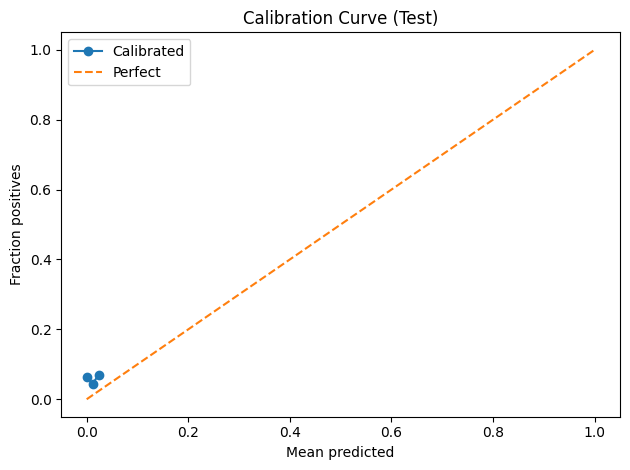

Calibration intercept=0.060, slope=-0.000


In [35]:

# === 17) Calibration (Test) ===
frac_pos, mean_pred = calibration_curve(yte, pte, n_bins=10, strategy="quantile")
plt.figure(); plt.plot(mean_pred, frac_pos, "o-", label="Calibrated")
plt.plot([0,1],[0,1],"--", label="Perfect"); plt.legend()
plt.xlabel("Mean predicted"); plt.ylabel("Fraction positives"); plt.title("Calibration Curve (Test)")
plt.tight_layout(); plt.show()

# Calibration intercept & slope
eps = 1e-12
p = np.clip(pte, eps, 1-eps)
logit_p = np.log(p/(1-p))
import statsmodels.api as sm
X_cal = sm.add_constant(logit_p)
cal_model = sm.OLS(yte, X_cal).fit()
intercept, slope = cal_model.params
print(f"Calibration intercept={intercept:.3f}, slope={slope:.3f}")


## **Evaluation — Decision Curve Analysis (Net Benefit)**

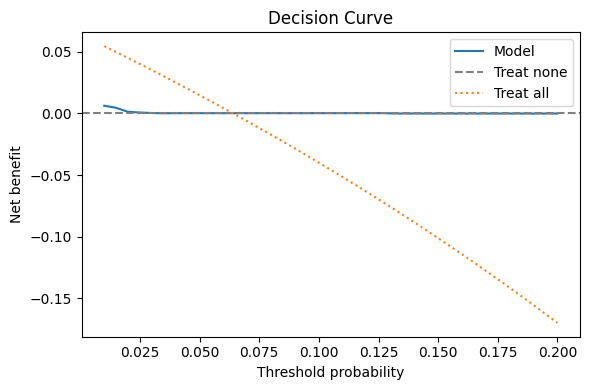

In [36]:

# === 18) Decision Curve Analysis ===
def decision_curve_net_benefit(y_true, p_hat, thresholds):
    y_true = np.asarray(y_true).astype(int)
    p_hat  = np.asarray(p_hat)
    N = y_true.size
    out = []
    for pt in thresholds:
        preds = (p_hat >= pt).astype(int)
        TP = np.sum((preds==1) & (y_true==1))
        FP = np.sum((preds==1) & (y_true==0))
        nb = (TP/N) - (FP/N) * (pt/(1-pt))
        out.append((pt, nb))
    return pd.DataFrame(out, columns=["threshold","net_benefit"])

ths = np.linspace(0.01, 0.20, 40)
dca = decision_curve_net_benefit(yte, pte, ths)
plt.figure(figsize=(6,4))
plt.plot(dca["threshold"], dca["net_benefit"], label="Model")
plt.axhline(0, color="gray", linestyle="--", label="Treat none")
prev = yte.mean()
plt.plot(dca["threshold"], prev - (1-prev)*(dca["threshold"]/(1-dca["threshold"])), label="Treat all", linestyle=":")
plt.xlabel("Threshold probability"); plt.ylabel("Net benefit"); plt.legend(); plt.title("Decision Curve")
plt.tight_layout(); plt.show()


## **Evaluation — Rural‑Urban Subgroup Metrics**

In [37]:

# === 19) Subgroup (Rural-Urban Continuum Code) ===
ru_col = "Rural-Urban Continuum Code" if "Rural-Urban Continuum Code" in X_test.columns else None
if ru_col:
    for val in X_test[ru_col].dropna().unique():
        idx = (X_test[ru_col] == val)
        if idx.sum() < 50:
            continue
        auc = roc_auc_score(yte[idx], pte[idx])
        ap  = average_precision_score(yte[idx], pte[idx])
        print(f"[{ru_col}={val}] n={idx.sum()} | AUC={auc:.3f} | PR-AUC={ap:.3f}")


[Rural-Urban Continuum Code=Counties in metropolitan areas ge 1 million pop] n=1663 | AUC=0.506 | PR-AUC=0.065
[Rural-Urban Continuum Code=Counties in metropolitan areas of 250,000 to 1 million pop] n=883 | AUC=0.501 | PR-AUC=0.085
[Rural-Urban Continuum Code=Nonmetropolitan counties adjacent to a metropolitan area] n=282 | AUC=0.485 | PR-AUC=0.092
[Rural-Urban Continuum Code=Nonmetropolitan counties not adjacent to a metropolitan area] n=227 | AUC=0.492 | PR-AUC=0.063
[Rural-Urban Continuum Code=Counties in metropolitan areas of lt 250 thousand pop] n=224 | AUC=0.429 | PR-AUC=0.031


## **Evaluation — Risk Deciles & Capture**

In [38]:

# === 20) Risk Deciles / Capture Rate ===
df_eval = pd.DataFrame({"proba": pte, "y": yte})
df_eval["decile"] = pd.qcut(df_eval["proba"], 10, labels=False, duplicates="drop")
summary = df_eval.groupby("decile").agg(
    n=("y", "size"),
    positives=("y", "sum"),
    mean_proba=("proba", "mean")
).sort_index(ascending=False)
summary["cum_pos"] = summary["positives"].cumsum()
summary["cum_pos_pct"] = summary["cum_pos"] / summary["positives"].sum()
display(summary)


,n,positives,mean_proba,cum_pos,cum_pos_pct
decile,,,,,
1,271,19,0.023375,19,0.090476
0,3008,191,0.000620,210,1.000000
